GeoTIFF and other raster formats are commonly used to organize and store gridded raster datasets such as satellite imagery, land use/cover data and terrain models, etc. 
### 📖Rasterio
``Rasterio`` is a useful library for reading and writing these formats and provides a Python API based on ``Numpy ``N-dimensional arrays and GeoJSON. Before ``Rasterio`` there was one Python option for accessing the many different kind of raster data files used in the GIS field: the Python bindings distributed with the Geospatial Data Abstraction Library, ``GDAL``. 


Next, we will be reading a raster file of ``Africa.tif``, which contains population data and urban settlements, and doing some common processes on it. Lets' import a couple of libraries that will be using:

In [21]:
!pip install bokeh
!pip install scikit-image

     ---------------------------------------- 0.0/22.8 MB ? eta -:--:--
      --------------------------------------- 0.5/22.8 MB 9.6 MB/s eta 0:00:03
     - -------------------------------------- 1.0/22.8 MB 10.5 MB/s eta 0:00:03
     -- ------------------------------------- 1.6/22.8 MB 11.0 MB/s eta 0:00:02
     --- ------------------------------------ 2.1/22.8 MB 11.2 MB/s eta 0:00:02
     ---- ----------------------------------- 2.7/22.8 MB 11.4 MB/s eta 0:00:02
     ----- ---------------------------------- 3.3/22.8 MB 11.5 MB/s eta 0:00:02
     ------ --------------------------------- 3.8/22.8 MB 11.6 MB/s eta 0:00:02
     ------- -------------------------------- 4.4/22.8 MB 11.6 MB/s eta 0:00:02
     -------- ------------------------------- 4.9/22.8 MB 11.6 MB/s eta 0:00:02
     --------- ------------------------------ 5.5/22.8 MB 11.6 MB/s eta 0:00:02
     ---------- ----------------------------- 6.0/22.8 MB 11.6 MB/s eta 0:00:02
     ----------- ---------------------------- 6.6

In [7]:
import rasterio        # for reading raster data
import bokeh           # for data visualization 
import urllib.request  # for reading data from a URL
import os              # interacting with the operating system 

Download the multi-layer GeoTIFF, Africa.tif from [here](https://git.rwth-aachen.de/nfdi4earth/edutrain/content/extern/python-for-spatial-data-analysis/-/raw/main/Data/Africa.tif?inline=false):

In [3]:
if os.path.isfile('Data/Africa.tif'):
    print("Africa.tif already in the current working directory(cwd).")
else:
    print("the file can not be found.")

Africa.tif already in the current working directory(cwd).


Let's open the file with rasterio:

In [8]:
africa_tif = rasterio.open('Data/Africa.tif')

Print some metadata of the dataset:

In [9]:
print("The file is called", africa_tif.name, "\n")
print("It contains", africa_tif.width, "x",africa_tif.height,"pixels")
print()
print("It covers the following extent:",africa_tif.bounds)
print()
print("It is in the following CRS:",africa_tif.crs)

The file is called Data/Africa.tif 

It contains 10663 x 10117 pixels

It covers the following extent: BoundingBox(left=-25.360422329999892, bottom=-46.96575286299996, right=63.493907097000005, top=37.34520091400016)

It is in the following CRS: EPSG:4326


In [10]:
# what is the pixel size of the raster ?
pixelSizeX, pixelSizeY  = africa_tif.res
print (pixelSizeX)
print (pixelSizeY)
# what is the unit?

0.008332957838038066
0.008333592347237335


How many layers are there in this GeoTIFF, and what data types do they use?

In [6]:
{i: dtype for i, dtype in zip(africa_tif.indexes, africa_tif.dtypes)}

{1: 'int16', 2: 'int16', 3: 'int16', 4: 'int16'}

Let's take a look at the layers:

In [7]:
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

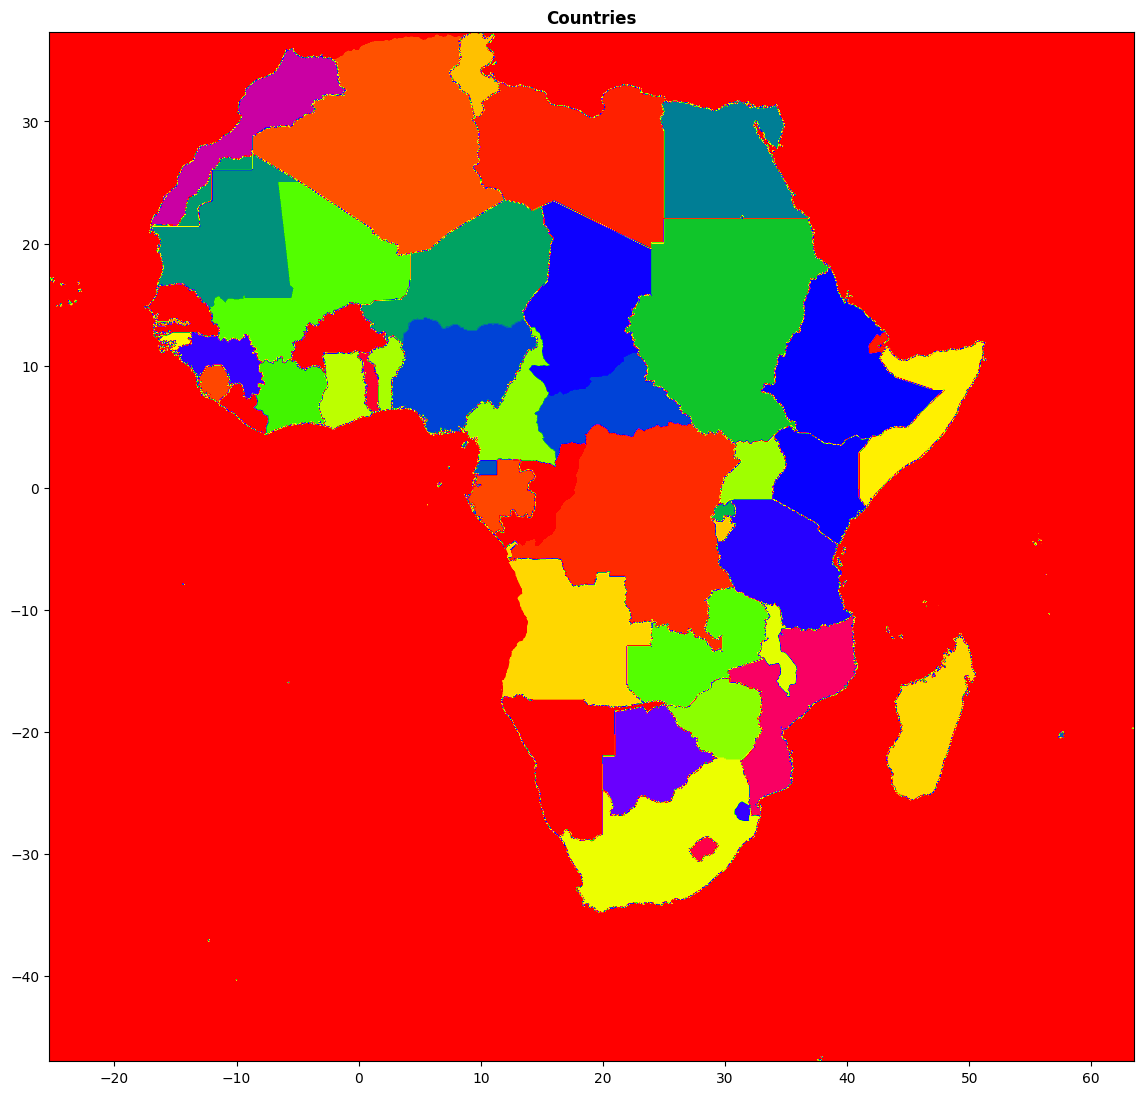

<Axes: title={'center': 'Countries'}>

In [8]:
plt.figure(figsize=(14, 14))
# remember the file has 4 raster layers (countries, Urban, population, )

show((africa_tif, 1), title='Countries', cmap='prism') # reading the first layer, hence layer indexed 1 is shown

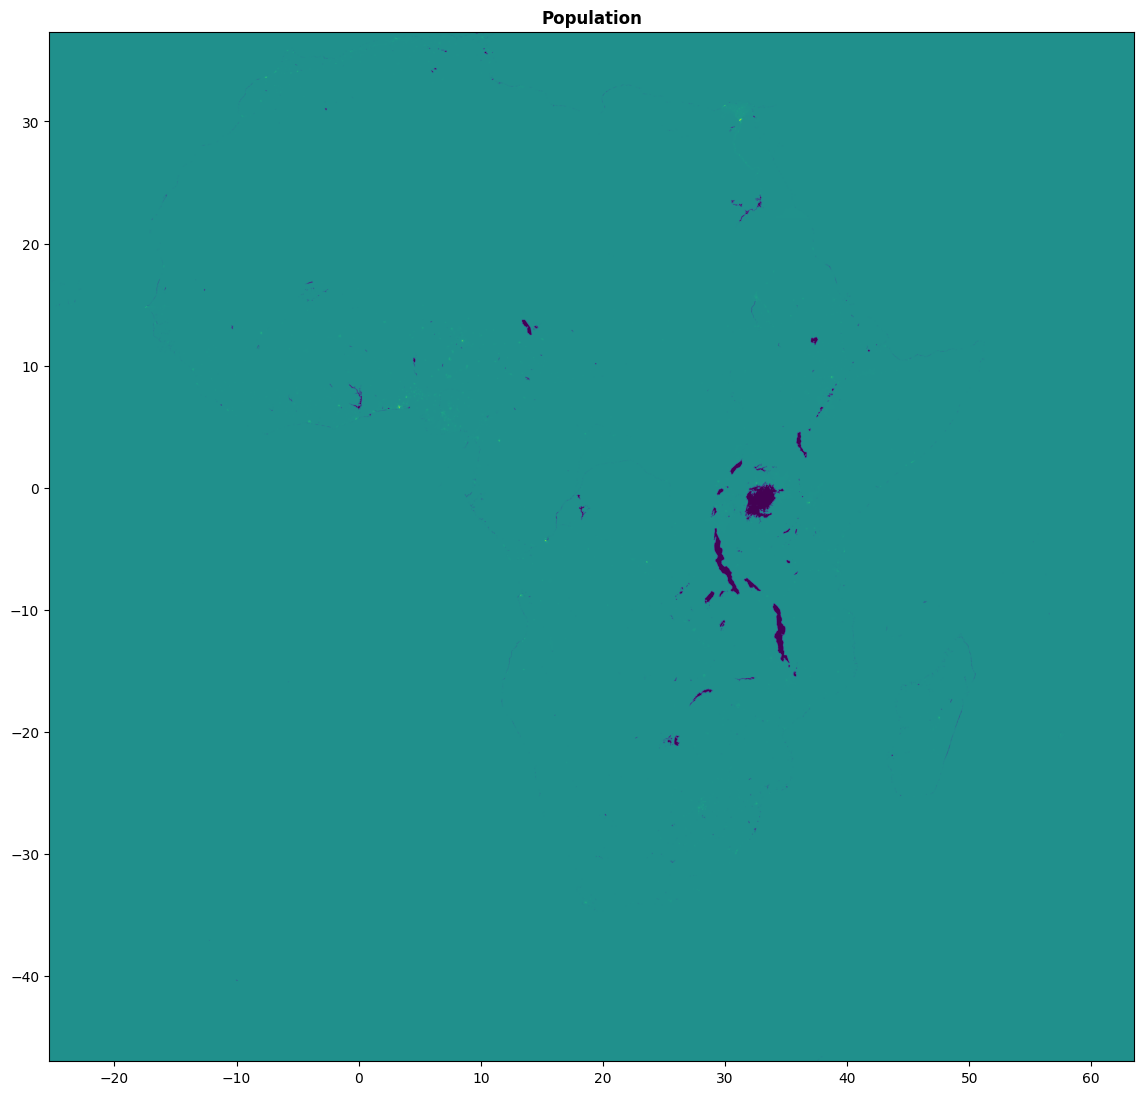

<Axes: title={'center': 'Population'}>

In [9]:
plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population')

Not great, let's try to improve this:

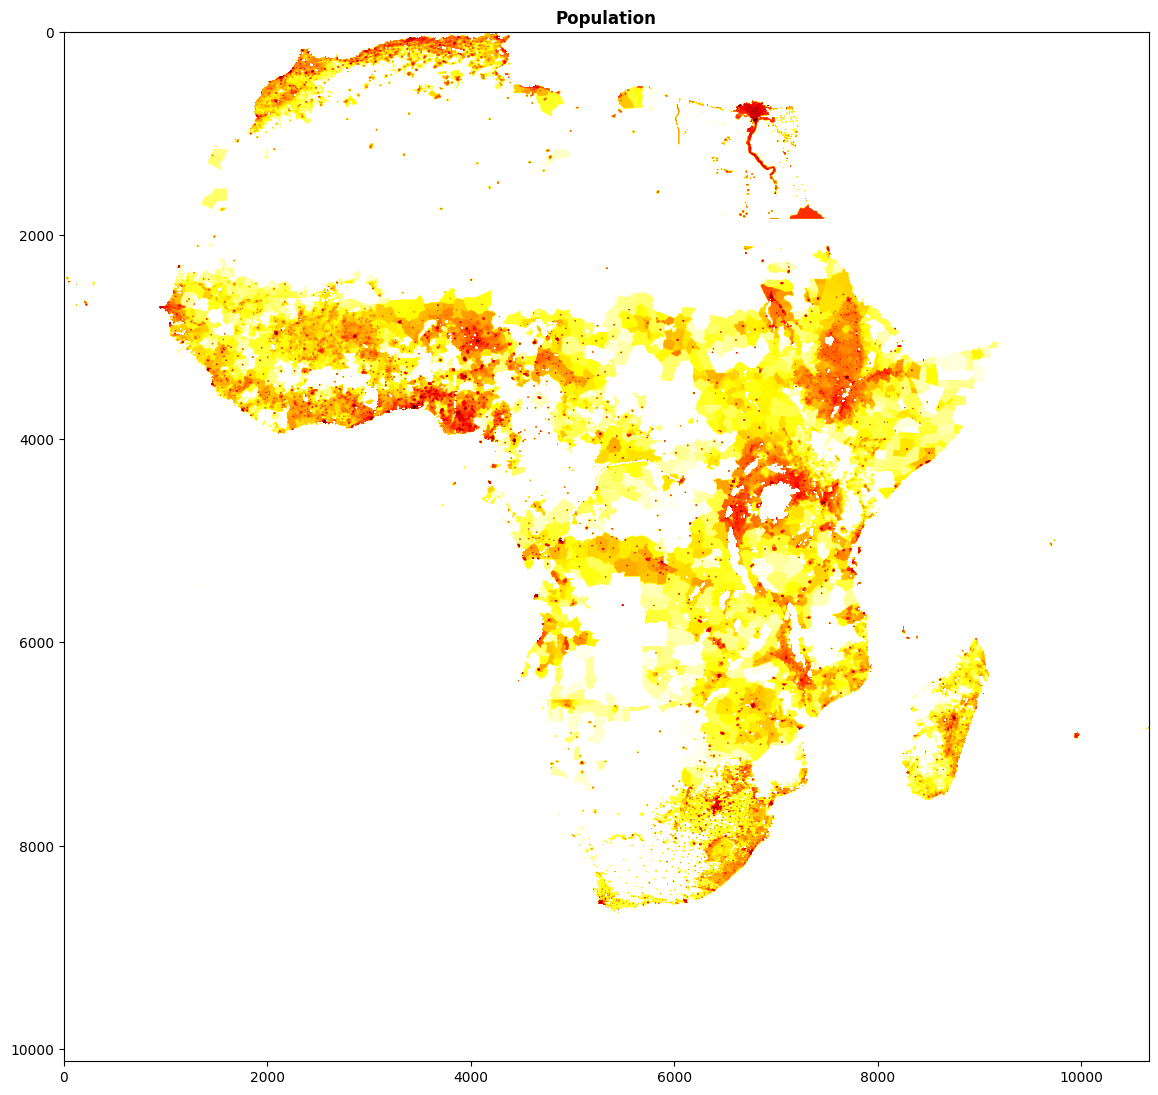

<Axes: title={'center': 'Population'}>

In [10]:
from matplotlib.colors import LogNorm

pop = africa_tif.read(2)  # reading the layer 2 and putting into POP variable

plt.figure(figsize=(14, 14))
show(pop, title='Population', norm=LogNorm(), cmap='hot_r')

Can we add a legend?

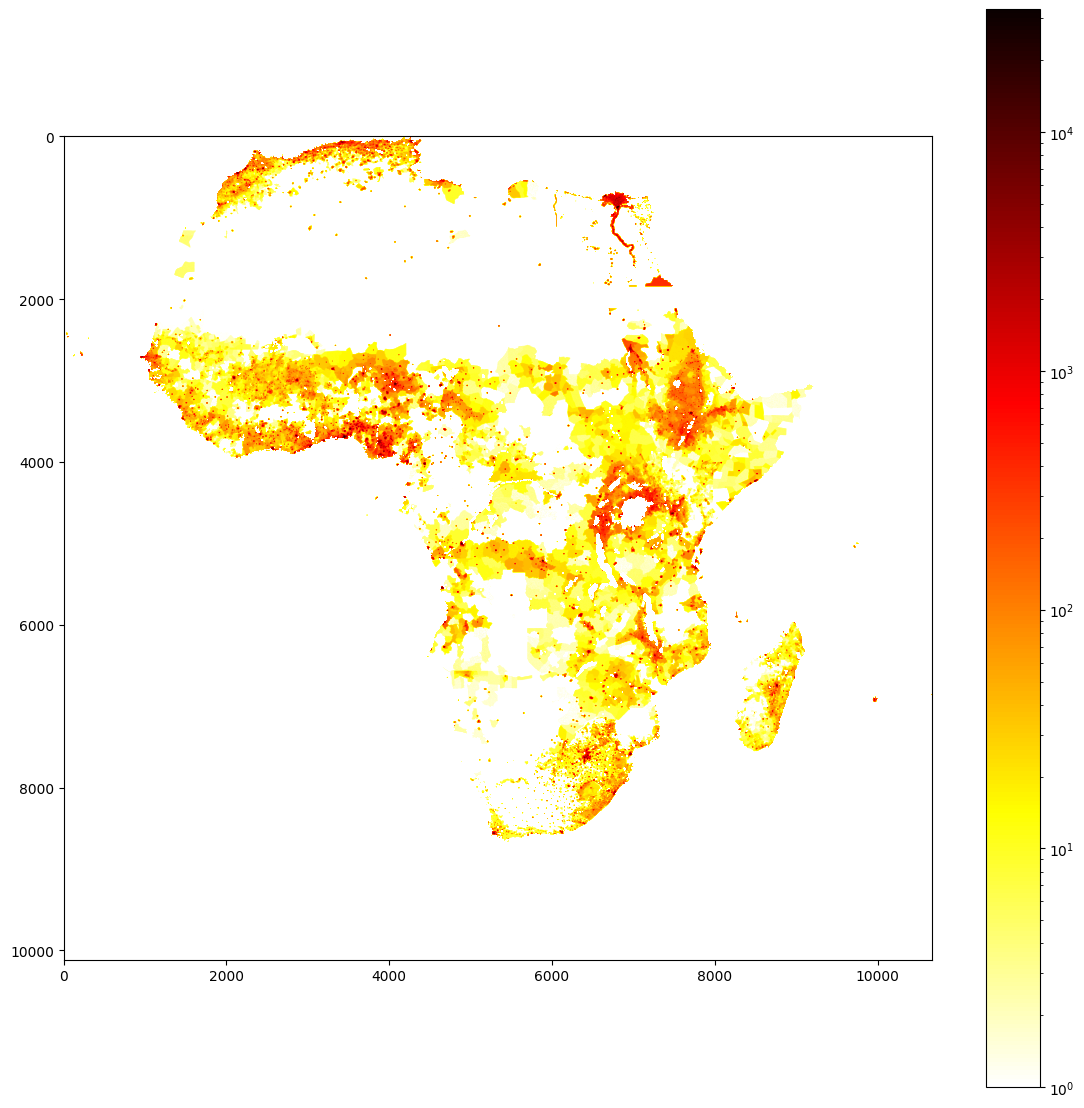

In [11]:
plt.figure(figsize=(14, 14))

imgplot = plt.imshow(pop, norm=LogNorm(), cmap='hot_r')
plt.colorbar() # adding the legend

### 📖Interactive plots with Bokeh
Bokeh is a charting tool: it lets you create interactive web charts in Python and automatically displays them in the browser through its BokehJS library in JavaScript. It could be an alternative tool to do what we just did!

In [12]:
import numpy as np
import bokeh.plotting as bkplt

In [13]:
pop.shape

(10117, 10663)

In [14]:
p = bkplt.figure(x_range=(0, pop.shape[0]), y_range=(0, pop.shape[1]))

# must give a vector of image data for image parameter
p.image(image=[pop], x=0, y=0, dw=pop.shape[0], dh=pop.shape[1], palette="Spectral11")

bkplt.show(p)

What did just happen? Maybe you saw something like:


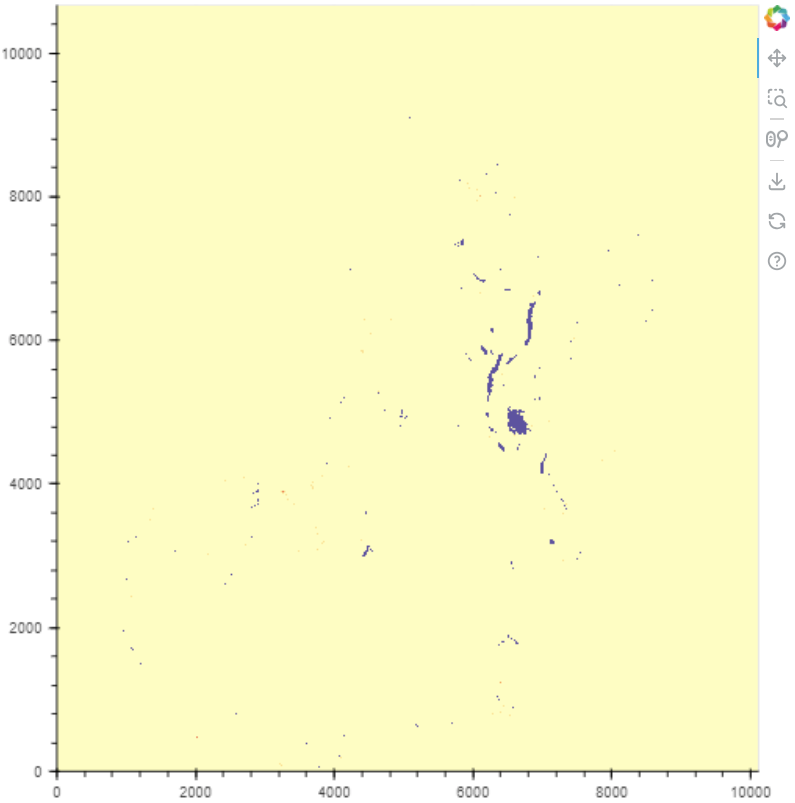

### 🧠Dive Deeper
explore [holoviews](https://towardsdatascience.com/displaying-a-gridded-dataset-on-a-web-based-map-ad6bbe90247f) for better interactive maps.

### 📖Raster File Compression

The size of raster files can sometimes become very large. Most of computational/modelling/simulation tasks as well as satellite data are large and storing/processing//transfering them can save up a lot time and pain in your code of even softwares. So compressing them can substantially reduce the disk space usage of them.

``LZW`` is one of the compression methods that we will apply below using a function.

In [15]:
def compress(inputfile, outputfile, layer, compression, datatype):
    
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)

        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

In [16]:
compress(africa_tif, 'pop-float.tif',     pop, None, rasterio.float32)
compress(africa_tif, 'pop-float-lzw.tif', pop, 'lzw', rasterio.float32)
compress(africa_tif, 'pop-int-lzw.tif',   pop, 'lzw', rasterio.int32)

In [17]:
# perhaps an easier way of calling metadata of your raster file
africa_tif.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 10663, 'height': 10117, 'count': 4, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.008332957838038066, 0.0, -25.360422329999892,
       0.0, -0.008333592347237335, 37.34520091400016), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

Let's do the urban layer to test int8:

In [18]:
urban = africa_tif.read(3)
compress(africa_tif, 'urban-int-lzw.tif', urban, 'lzw', rasterio.int8)

check the volume of the pop file before and after compression👀

### 📖Map Algebra [Raster Math]

Map algebra basically involves doing math with maps. But the key difference is that it only applies to raster data. That’s why we also call it raster math. More about it at [here](https://gisgeography.com/map-algebra-global-zonal-focal-local/).

In [22]:
import seaborn as sns     
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

Let's define two layers in the form of ``numpy`` arrays, let's say one is ground elevation, the other one is the height of vegeation above ground:


In [23]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

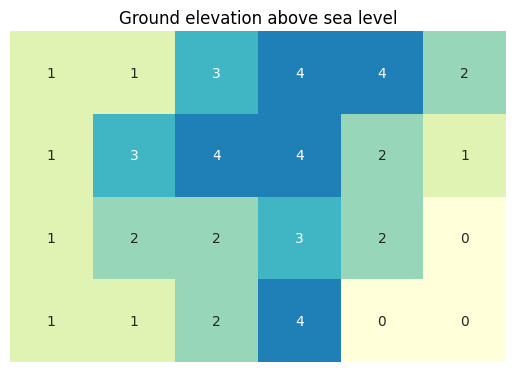

In [24]:
fig = sns.heatmap(elevation, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sea level')

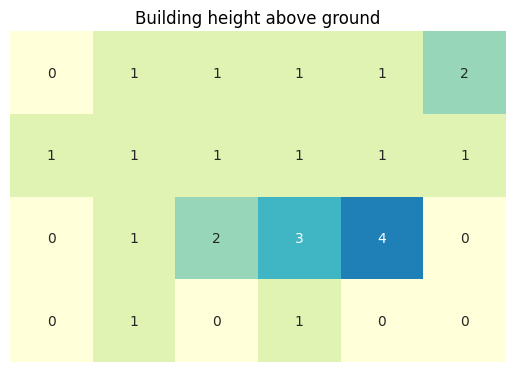

In [25]:
fig = sns.heatmap(building, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')

### 📖Local Operation 
Let's alculate building height above sea level:

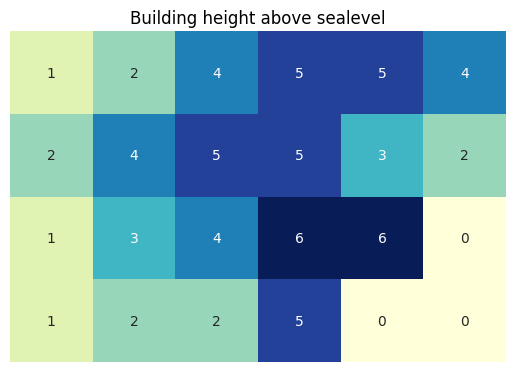

In [26]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')

### 📖Focal Operation
Let's assume our elevation raster has a measurement error and fix the errors in elevation raster, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value (we are manipulating the dataset to embed that in the file):

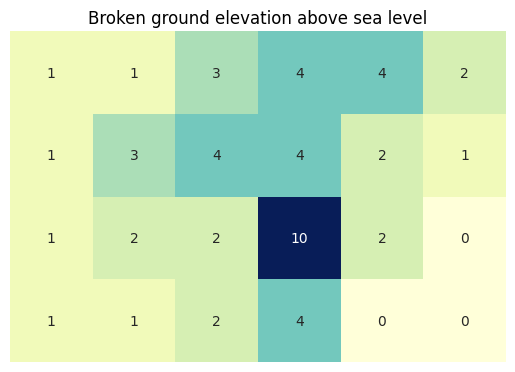

In [27]:
broken_elevation = elevation
broken_elevation[2,3] = 10 # replacing the element 2,3 (row 2 and column 3, note we start counting from 0 and from top-left as source) of the array into 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sea level')

We'll fix this by running a 3x3 window/kernel over it that sets every pixel to the average of its 8 neighbors:

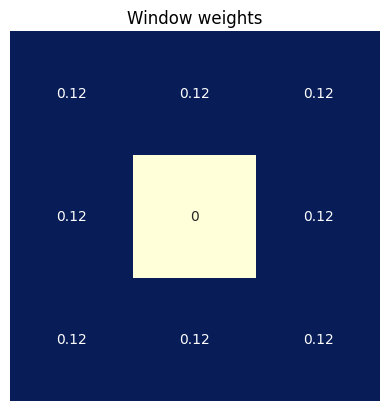

In [28]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])


fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Window weights')

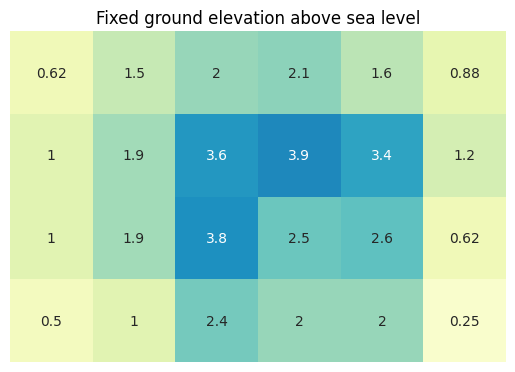

In [29]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sea level')

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

### 📖Zonal operation

Let's define two zones (two different land cover types) and calculate the average vegetation height per zone:

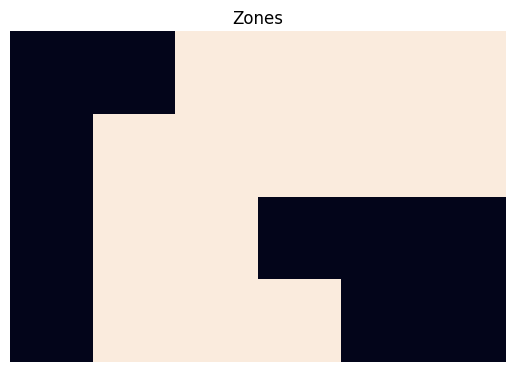

In [30]:
# making the two zones using a numpy array
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')

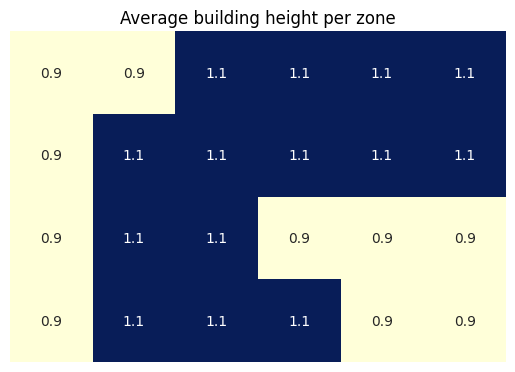

In [31]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
                  cbar=False).set_title('Average building height per zone')

### ✏️Task
how about the average elevation per zone?

In [ ]:
# Your solution here:

How about the the min and max building and elevation values?

In [ ]:
# Your solution here:

### 📖Global Operation

We'll use our elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.
A cost surface, or cost grid, is a raster grid in which the value in each cell is the cost that a particular activity or object would be in that cell. It can also be an indexed value based on costliness. Costs could be measured monetarily or in other ways such as amount of time. A cost surface includes the cost of reaching certain cells from one or more source cells.

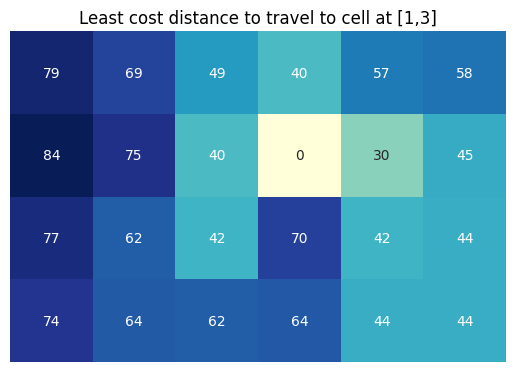

In [32]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [33]:
from skimage.graph import route_through_array

In [34]:
route_through_array(elevation, [3, 5], [1, 3])

([(3, 5), (2, 5), (1, 4), (1, 3)], 4.414213562373095)

### 📖Numpy

In [35]:
pop

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [36]:
pop.size

107877571

In [37]:
pop.shape

(10117, 10663)

In [38]:
pop[pop > 1000]

array([1258, 1284, 1265, ..., 3198, 2527, 1315], dtype=int16)

In [39]:
countries = africa_tif.read(1)

In [40]:
egypt = countries == 818 # = country code of Egypt is 818
egypt

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Combining layers!

In [41]:
np.sum(pop[egypt]) # what is happening here?

-108620901

Wait, what? Let's fix that:

In [42]:
pop[pop < 0] = 0

In [43]:
popegypt = np.sum(pop[egypt]) 
"{:,}".format(popegypt)

'81,662,875'

Identify the urban and rural cells in Egypt:

In [44]:
cities = urban == 2
rural  = urban == 1

Now we can count them to calculate the number of urban and rural cells in Egypt (or any other country) in 2010:

In [45]:
urbanEgypt = np.all((egypt, cities), axis=0)
ruralEgypt = np.all((egypt, rural), axis=0)

When applied to boolean arrays, [np.sum](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sum.html) treats ```True``` like 1 and ```False``` like 0:

In [46]:
print("Urban cells in Egypt:","{:,}".format(np.sum(urbanEgypt)))
print("Rural cells in Egypt:","{:,}".format(np.sum(ruralEgypt)))

Urban cells in Egypt: 33,689
Rural cells in Egypt: 1,267,349


### 🧠Dive Deeper

Let's take a look [here](https://bl.ocks.org/atanumallick/8d18989cd538c72ae1ead1c3b18d7b54) and [here](https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e)

### ✏️Task

Calculate the *total* population and *urban* population for each country in Africa.

In [ ]:
# Your solution here:

Generate a raster that indicates the distance to the closest urban cell for every cell in the output raster and visualize that raster.

First, pick out all the urban cells, which will be our source cells for the cost surface:

In [47]:
u = np.where(urban == 2)
u

(array([   1,    1,    1, ..., 8633, 8633, 8633], dtype=int64),
 array([4220, 4221, 4222, ..., 5364, 5365, 5371], dtype=int64))

Zip the two arrays to get the x and y positions of our urban source cells as a pair of indeces that we can pass on the the least cost surface calculation:

In [48]:
urbanIndexes = [(x,y) for x,y in zip(u[0], u[1])]
urbanIndexes

[(1, 4220),
 (1, 4221),
 (1, 4222),
 (1, 4223),
 (2, 4219),
 (2, 4220),
 (2, 4221),
 (2, 4222),
 (2, 4223),
 (2, 4224),
 (2, 4225),
 (3, 4219),
 (3, 4220),
 (3, 4221),
 (3, 4222),
 (3, 4223),
 (3, 4224),
 (3, 4225),
 (4, 4218),
 (4, 4219),
 (4, 4220),
 (4, 4221),
 (4, 4222),
 (4, 4223),
 (4, 4224),
 (4, 4225),
 (5, 4217),
 (5, 4218),
 (5, 4219),
 (5, 4220),
 (5, 4221),
 (5, 4222),
 (5, 4223),
 (5, 4224),
 (5, 4225),
 (6, 4217),
 (6, 4218),
 (6, 4219),
 (6, 4220),
 (6, 4221),
 (6, 4222),
 (6, 4223),
 (6, 4224),
 (6, 4225),
 (7, 4216),
 (7, 4217),
 (7, 4218),
 (7, 4219),
 (7, 4220),
 (7, 4221),
 (7, 4222),
 (7, 4223),
 (7, 4224),
 (7, 4225),
 (8, 4217),
 (8, 4218),
 (8, 4219),
 (8, 4220),
 (8, 4221),
 (8, 4222),
 (8, 4223),
 (8, 4224),
 (8, 4225),
 (9, 4215),
 (9, 4216),
 (9, 4217),
 (9, 4218),
 (9, 4219),
 (9, 4220),
 (9, 4221),
 (9, 4222),
 (9, 4223),
 (9, 4224),
 (9, 4228),
 (9, 4229),
 (9, 4248),
 (9, 4249),
 (10, 4216),
 (10, 4217),
 (10, 4218),
 (10, 4219),
 (10, 4220),
 (10, 4221)

Make a "fake" cost surface where the cost for each cell is 1:

In [49]:
fake_cost = np.ones_like(pop)
fake_cost

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int16)

Calculate the cost surface:

In [50]:
lg = graph.MCP_Geometric(fake_cost)

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=urbanIndexes)[0]

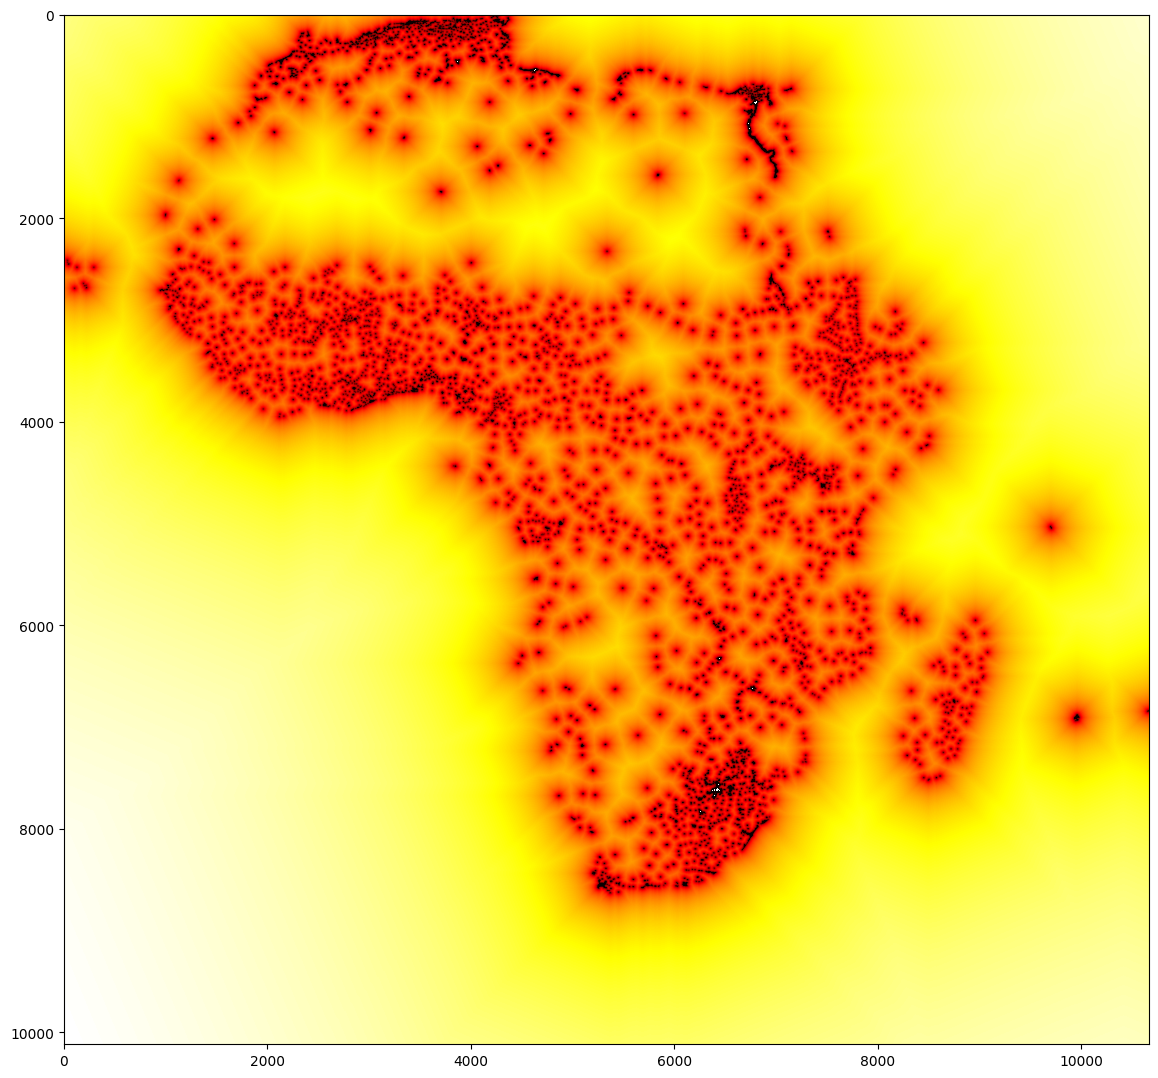

In [51]:
plt.figure(figsize=(14, 14))
imgplot = plt.imshow(lcd, norm=LogNorm(), cmap='hot')

In [52]:
lg.find_costs(starts=urbanIndexes)

(array([[1956.16897322, 1955.16897322, 1954.16897322, ..., 3810.96168697,
         3811.96168697, 3812.96168697],
        [1955.75475966, 1954.75475966, 1953.75475966, ..., 3810.54747341,
         3811.54747341, 3812.54747341],
        [1955.3405461 , 1954.3405461 , 1953.3405461 , ..., 3810.13325985,
         3811.13325985, 3812.13325985],
        ...,
        [5865.02423794, 5864.02423794, 5863.02423794, ..., 3267.        ,
         3267.41421356, 3267.82842712],
        [5865.4384515 , 5864.4384515 , 5863.4384515 , ..., 3268.        ,
         3268.41421356, 3268.82842712],
        [5865.85266507, 5864.85266507, 5863.85266507, ..., 3269.        ,
         3269.41421356, 3269.82842712]]),
 array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [5, 5, 5, ..., 6, 7, 7],
        [3, 3, 3, ..., 6, 7, 7],
        [5, 5, 5, ..., 6, 7, 7]], dtype=int16))

In [54]:
u = urban == 2

for c in np.unique(countries):
    
    incountry = countries == c
    
    print(c, "total:", "{:,}".format(np.sum(pop[incountry])))
    print(c, "urban:", "{:,}".format(np.sum(pop[np.all((incountry, u), axis=0)])))

0 total: 0
0 urban: 0
12 total: 38,615,393
12 urban: 23,453,970
24 total: 22,163,601
24 urban: 11,015,239
72 total: 2,422,366
72 urban: 1,226,879
108 total: 8,381,284
108 urban: 920,779
120 total: 22,517,640
120 urban: 11,312,845
132 total: 499,673
132 urban: 279,265
140 total: 4,532,869
140 urban: 1,701,565
148 total: 11,650,688
148 urban: 3,101,414
174 total: 681,595
174 urban: 199,135
178 total: 4,122,015
178 urban: 2,502,690
180 total: 67,391,405
180 urban: 22,773,233
204 total: 9,045,816
204 urban: 3,719,475
226 total: 1,147,244
226 urban: 256,952
231 total: 83,073,461
231 urban: 13,812,296
232 total: 5,206,923
232 urban: 1,099,901
262 total: 939,246
262 urban: 623,722
266 total: 1,961,972
266 urban: 1,222,524
270 total: 1,698,270
270 urban: 992,289
288 total: 25,099,168
288 urban: 12,494,757
324 total: 9,897,569
324 urban: 3,491,268
384 total: 20,213,177
384 urban: 9,457,883
404 total: 39,897,613
404 urban: 8,507,301
426 total: 2,171,319
426 urban: 583,629
430 total: 4,002,375
43